# Timeseries Forecasting (with Tensorflow)

### Outline
1. Forecast for a single time step:
    - A single feature.
    - All features.
2. Forecast multiple steps:
    - Single-shot: Make the predictions all at once.
    -Autoregressive: Make one prediction at a time and feed the output back to the model.

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The Weather Dataset

- This weather time series dataset was recorded by the Max Planck Institute for Biogeochemistry

- Has 14 different features (like air pressure, humidity

- Collected every 10 minutes since '03

- This section of the dataset was prepared by François Chollet for his book Deep Learning with Python

- We're going to use hourly data

In [2]:
zip_path = tf.keras.utils.get_file(origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
                                   fname='jena_climate_2009_2016.csv.zip',
                                   extract=True)
csv_path, _ = os.path.splitext(zip_path)

13582336/13568290 [==============================] - 0s 0us/step


In [4]:
df = pd.read_csv(csv_path)
# change 10m -> hourly [start:stop:step]
df = df[5::6]
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


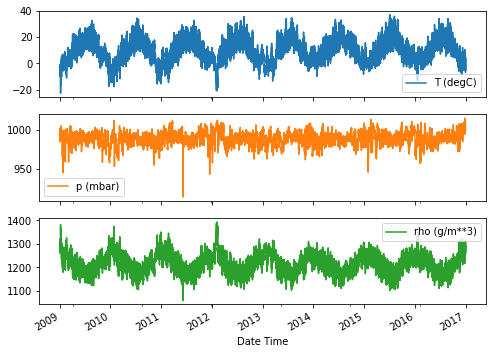

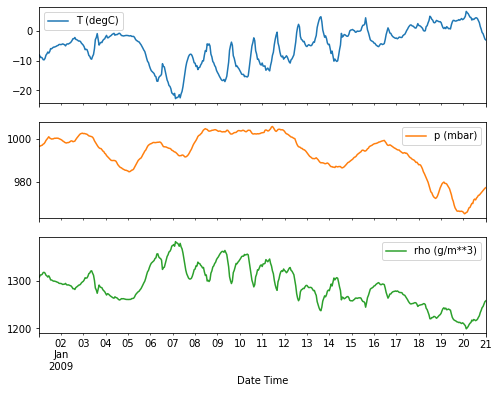

In [5]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


- -9999 is likely erroneous for wind velocity

- we will replace with 0s

In [7]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# Feature engineering

- The wd (deg) column gives wind direction in terms of degrees

- Doesn't make sense because 0 and 360 are close

- Distribution looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

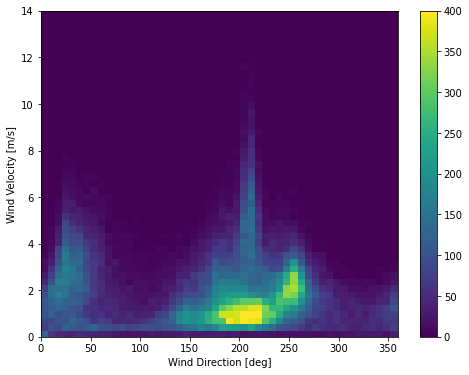

In [8]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

- convert to a wind vector instead so it makes sense to the model

In [9]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

wd_rad = df.pop('wd (deg)')*np.pi / 180 # to radians

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

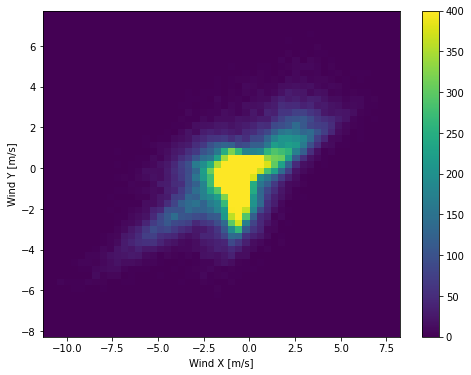

In [10]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

### Time

- Datetime is also very useful but in the correct form

- Here, we convert to seconds and then transform to a wave to to get a good representation of "time of day" and "time of year"

In [11]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

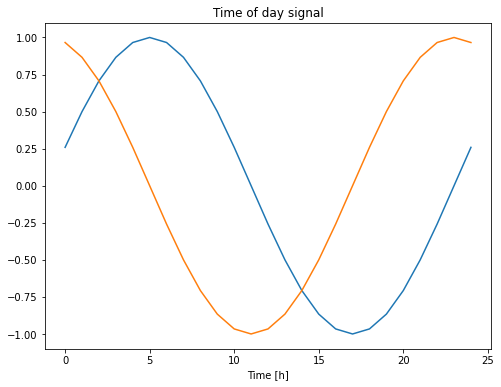

In [12]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

- Doing this gives the model access to the most important frequency features.
- In this case you knew ahead of time which frequencies were important.

- Determine which frequencies are important using the FFT


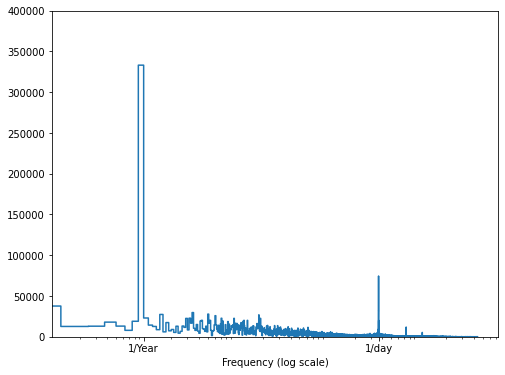

In [13]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Split Data

- We'll use 70, 20, 10 for train, val, test


In [14]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the Data

- Normalization is a common way of doing this scaling:
    - subtract the mean and divide by the standard deviation of each feature
- Should only compute mean and std on training set so there is no data leakage

- Note some people say you shouldn't have access to future values in the train set either, but here we will

In [15]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

- Note below how there are some fat tails

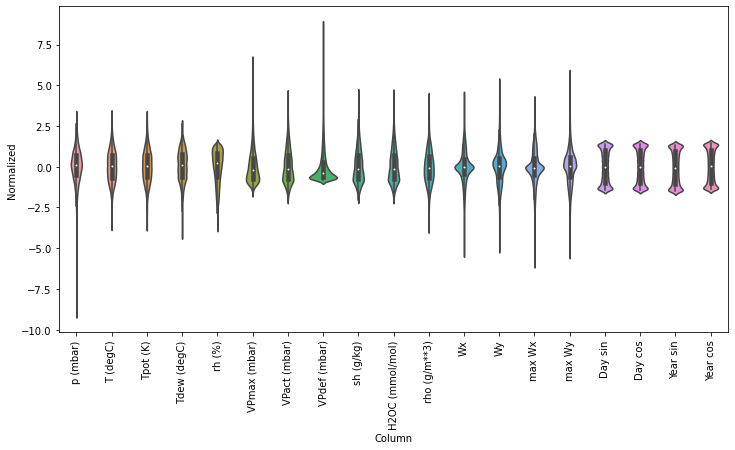

In [16]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

- Data Windowing

- We'll make predictions based on a context window of previous timesteps

- The inputs window considers three things:
    - the width of X and y window
    - the time offset between them
    - which features to keep as inputs and labels



In [61]:
class WindowGenerator():
  def __init__(self,
               input_width,
               label_width,
               shift,
               train_df=train_df,
               val_df=val_df,
               test_df=test_df,
               label_columns=None):
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result



In [50]:
w1 = WindowGenerator(input_width=24,
                     label_width=1,
                     shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [51]:
w2 = WindowGenerator(input_width=6,
                     label_width=1,
                     shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [42]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


In [43]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [44]:
single_step_window = WindowGenerator(input_width=1,
                                     label_width=1,
                                     shift=1,
                                     label_columns=['T (degC)'])

for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


# Building a Baseline

- Baselines are important for comparison with the later, more complicated models
- Should be simple

- Our model will predict the current value for the next time step, and is thus the same as shifting our dataset 1

In [45]:
class Baseline(tf.keras.Model):
    def __init__(self, label_idx=None):
        super().__init__()
        self.label_idx = label_idx
    
    def call(self, X):
        if self.label_idx is None:
            return X
        results = X[:, :, self.label_idx]
        return results[:, :, tf.newaxis]


In [46]:
baseline = Baseline(label_idx=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 2s 4ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


### Linear Model

In [52]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [53]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [54]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 10s 6ms/step - loss: 0.1239 - mean_absolute_error: 0.2056 - val_loss: 0.0095 - val_mean_absolute_error: 0.0724
Epoch 2/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0096 - mean_absolute_error: 0.0719 - val_loss: 0.0091 - val_mean_absolute_error: 0.0702
Epoch 3/20
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0094 - mean_absolute_error: 0.0713 - val_loss: 0.0090 - val_mean_absolute_error: 0.0697
Epoch 4/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0094 - mean_absolute_error: 0.0713 - val_loss: 0.0089 - val_mean_absolute_error: 0.0698
Epoch 5/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0093 - mean_absolute_error: 0.0710 - val_loss: 0.0089 - val_mean_absolute_error: 0.0694
Epoch 6/20
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0093 - mean_absolute_error: 0.0707 - val_loss: 0.0089 - val_mean_absolute_error: 0.0692
Epo

- Like the baseline model, the linear model can be called on batches of wide windows. 
- the model makes a set of independent predictions on consecutive time steps
- linear models are simple so we can visualize the weights per feature:

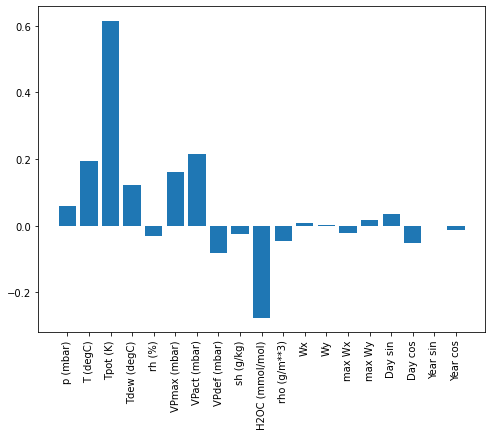

In [55]:
plt.bar(x = range(len(train_df.columns)),
                  height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)


### Dense Models
- introduce nonlinearity

In [56]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 11s 6ms/step - loss: 0.0179 - mean_absolute_error: 0.0821 - val_loss: 0.0075 - val_mean_absolute_error: 0.0627
Epoch 2/20
1534/1534 [==============================] - 14s 9ms/step - loss: 0.0079 - mean_absolute_error: 0.0647 - val_loss: 0.0071 - val_mean_absolute_error: 0.0604
Epoch 3/20
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0076 - mean_absolute_error: 0.0627 - val_loss: 0.0076 - val_mean_absolute_error: 0.0640
Epoch 4/20
1534/1534 [==============================] - 10s 6ms/step - loss: 0.0072 - mean_absolute_error: 0.0609 - val_loss: 0.0068 - val_mean_absolute_error: 0.0593
Epoch 5/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0070 - mean_absolute_error: 0.0599 - val_loss: 0.0073 - val_mean_absolute_error: 0.0613
Epoch 6/20
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0069 - mean_absolute_error: 0.0590 - val_loss: 0.0066 - val_mean_absolute_error: 0.0578
E

### Multi-step dense

- A single step model can't get a sense of how inputs change over time
- to address this, we use multiple timesteps in the input (windowed approach)



In [64]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
        input_width=CONV_WIDTH,
        label_width=1,
        shift=1,
        label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

In [58]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension. Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [59]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 2s 5ms/step - loss: 0.0059 - mean_absolute_error: 0.0530


- Downside of this approach is that the model can only use a fixed number of inputs

- Using a CNN can fix this issue and let us use inputs of varying length

### CNN

- The convolutional layer is applied to a sliding window of inputs

In [60]:
conv_model = tf.keras.Sequential([
    # note how we get rid of flatten
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [62]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 2s 4ms/step - loss: 0.0063 - mean_absolute_error: 0.0561


In [65]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


# RNN

- Process a series step-by-step and maintain an internal state from ts to ts
    - https://www.tensorflow.org/guide/keras/rnn
- we'll use LSTM which aims to fix the short-term memory issue of vanilla RNNs
- An important param is the return_sequences argument
    - if False, returns only the output of the final timestep
        - lets the model time to warm up its internal state before making a single prediction
    - if True, returns a single output per each input
        - useful for stacking RNN layers
        - Training a model for multiple timesteps simutanesouly
    


In [66]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True), # return_sequences=True, the model can be trained on 24 hours of data at a time
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [68]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 4s 8ms/step - loss: 0.0056 - mean_absolute_error: 0.0516


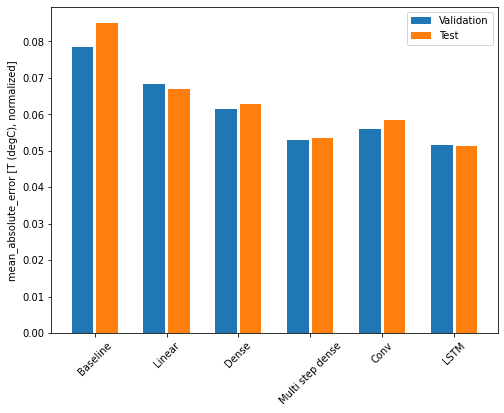

In [70]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

# Multi-output models

-  So far, only predicted a single output feature, T (degC), for a single time step
- to make multi-output, just change the output layer and adjust the windows used in window gen for labels


In [71]:
single_step_window = WindowGenerator(
        # `WindowGenerator` returns all features as labels if you 
        # don't set the `label_columns` argument.
        input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
        input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


In [72]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 2s 5ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


In [74]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 2s 5ms/step - loss: 0.0676 - mean_absolute_error: 0.1303


In [ ]:
%%time
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

# Residual connections

- the baseline performed decently because the values change very little between timesteps

- we had to train the NN to learn this because the weights are initially random

- Can get around this with careful weight init, or build it into the model structure

- Its common that istead of predicting the next timestep, predict how the value will change at the next timestep

- Likewise, ResNets refer to architectures where each layer adds to the model's accumulating result.

- If the value changes are small, this is how we take advantage of that:

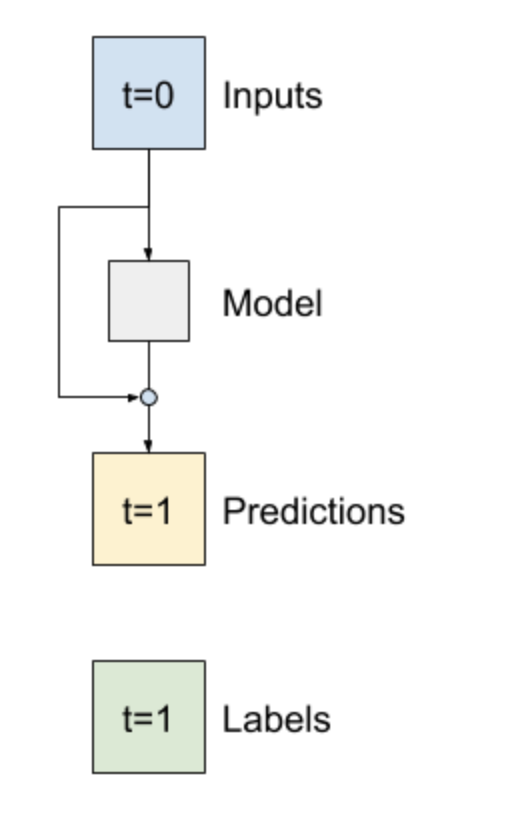




- the eseentially lets the model initialize to match the baseline
- the helps speed up convergence in these types of situations

### ResNet

- Here, we use with the LSTM model
- Note the use of the tf.initializers.zeros to make sure the initial predicted changes are small, and don't overpower the residual connection

In [75]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)
        # The prediction for each time step is the input from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [76]:
%%time
residual_lstm = ResidualWrapper(
        tf.keras.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.Dense(
            num_features,
            # The predicted deltas should start small.
            # Therefore, initialize the output layer with zeros.
            kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

438/438 [==============================] - 3s 7ms/step - loss: 0.0624 - mean_absolute_error: 0.1182

CPU times: user 4min 12s, sys: 20.4 s, total: 4min 32s
Wall time: 3min 39s


In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

# Multi-step models

- Both single and multi output models discussed above only predict for one timestep

- In a multi-step prediction, the model needs to learn to predict a range of future values
    - predicts a sequence of the future values

- Two ways to handle this:
    1. single shot prediction for all values
    2. autoregressive predictions
        - model output is fed back into the model
        - beware of compounding errors

- Here we'll predict all outputs across all timesteps

In [78]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

## Multistep Baseline

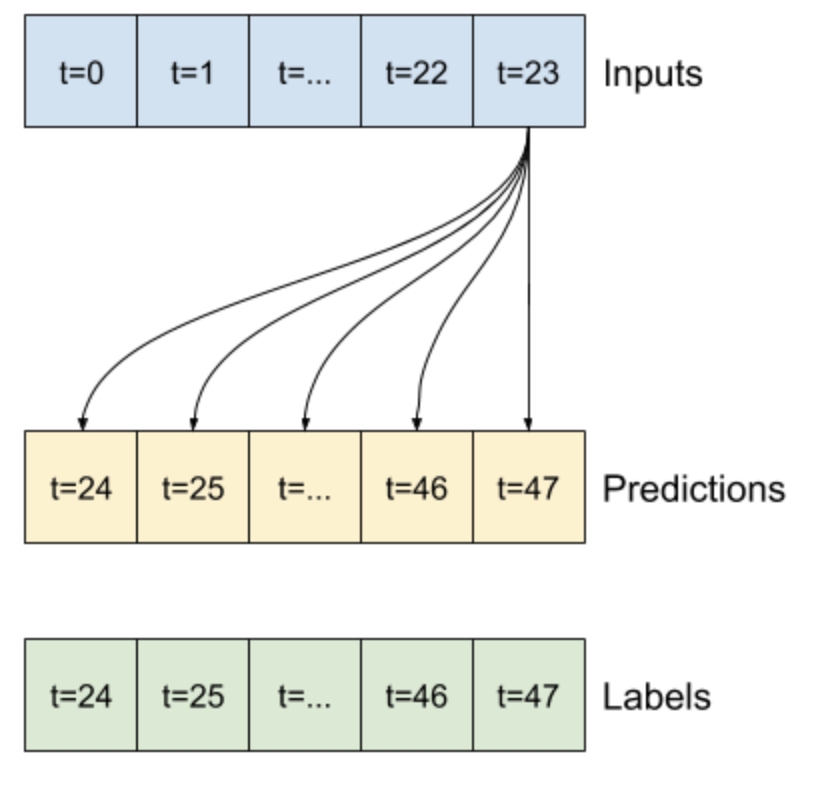

In [80]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)


437/437 [==============================] - 2s 5ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


In [82]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)


437/437 [==============================] - 4s 8ms/step - loss: 0.4270 - mean_absolute_error: 0.3959


## Singleshot Models

- model makes the entire sequence prediction in a single step

- This can be implemented efficiently as a tf.keras.layers.Dense with OUT_STEPS*features output units
    - needs to reshape that output to the required (OUTPUT_STEPS, features)


In [88]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)


437/437 [==============================] - 3s 6ms/step - loss: 0.2197 - mean_absolute_error: 0.2822


### CNN
- A convolutional model makes predictions based on a fixed-width history
- can see how things are changing over time, so might perform better than dense

In [85]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)


437/437 [==============================] - 3s 6ms/step - loss: 0.2169 - mean_absolute_error: 0.2833


### RNN

In [87]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

437/437 [==============================] - 4s 8ms/step - loss: 0.2146 - mean_absolute_error: 0.2850


# Autoregressive model

- each model's output can be fed back into itself at each step
- predictions can be made conditioned on the previous one
- set up to produce output with a varying length

- Focus on building a model that's been explicitly trained for autoregression

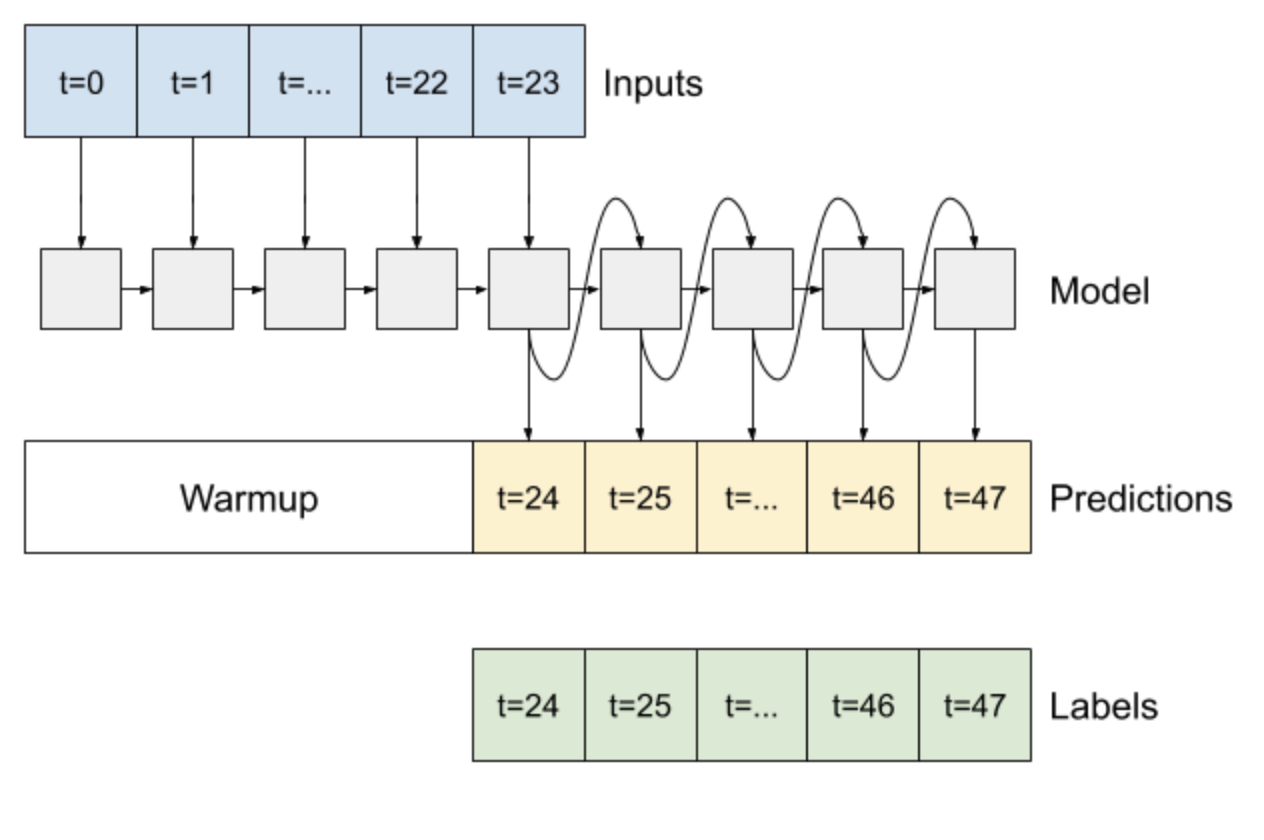

## Autoregressive RNN

Has the following:
    - a tf.keras.layers.LSTM layer
    - a tf.keras.layers.Dense layer that converts the LSTM layer's outputs to model predictions

- Note that a tf.keras.layers.LSTM is a tf.keras.layers.LSTMCell wrapped in the higher level tf.keras.layers.RNN that manages the state and sequence results for you
- We'll manually manage the inputs for each step, so we use tf.keras.layers.LSTMCell

In [89]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

    def warmup(self, inputs):
        """initialize its internal state based on the inputs
        this state will capture the relevant parts of the input history
        once trained
        """
        # inputs.shape => (batch, time, features) || x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state

    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                    training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [90]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape


TensorShape([32, 19])

In [91]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


In [93]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)


437/437 [==============================] - 4s 10ms/step - loss: 0.2300 - mean_absolute_error: 0.3037


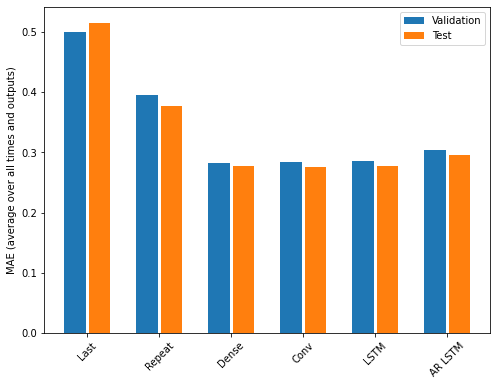

In [94]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

### Conclusion

- The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any)

- the autoregressive model performed clearly worse.

- So these more complex approaches may not be worth while on **this** problem, but may be on more complex problems